In [26]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from fbprophet import Prophet
from datetime import datetime
from numpy import array
from numpy import split
import matplotlib.pyplot as plt

In [2]:
timestr = time.strftime("%Y_%m_%d")
timestr = '2020_04_14'
df = pd.read_csv(r'..\..\data\dev_data\covid19_time_series_{}.csv'.format(timestr))
##Active is always zero...manually correct via simple calculation
df['Active'] = df['Confirmed'] - df['Deaths'] - df['Recovered']

## Multiple Linear Regression Approach

In [5]:
## really only need the date and confirmed columns but bringing along the other in case we want to predict any of them
country_df_regres = df.groupby(['Country','Date']).sum()[["Confirmed","Recovered","Active","Deaths"]].reset_index()
country_df_regres['Date'] = pd.to_datetime(country_df_regres['Date'])

In [14]:
## create lag variables from the last two weeks
for i in range(7, 15):
    country_df_regres[f'Confirmed_lag_{i}'] = country_df_regres.groupby('Country')['Confirmed'].shift(i)
    country_df_regres[f'Deaths_lag_{i}'] = country_df_regres.groupby('Country')['Deaths'].shift(i)
    country_df_regres[f'Recovered_lag_{i}'] = country_df_regres.groupby('Country')['Recovered'].shift(i)
    country_df_regres[f'Active_lag{i}'] = country_df_regres.groupby('Country')['Active'].shift(i)

In [95]:
prediction_country = 'United States of America'

In [96]:
df_train = country_df_regres.loc[country_df_regres['Country']==prediction_country]

In [97]:
df_train = df_train.dropna()

In [98]:
df_train=df_train.reset_index()
lag_cols_only =  [col for col in df_train.columns if 'Confirmed_lag_' in col]
X = df_train[lag_cols_only]
y = df_train['Confirmed']

In [100]:
num_in_test = 7
test_size = float(num_in_test) / len(X)
n_splits = int((1//test_size)-1)
tscv = TimeSeriesSplit(n_splits=n_splits)

In [101]:
y_preds = []
mapes =  []
model_coefs = []
first_test_ind = 50000
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    if test_index[0] < first_test_ind:
        first_test_ind=test_index[0]
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = LinearRegression()
    model.fit(X_train, y_train)
    model_coefs.append(model.coef_)
    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred)
    y_preds.append(y_pred)
    mapes.append(round((abs((y_pred -y_test) / y_test) * 100).mean()))
    

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16 17 18 19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20 21 22 23 24 25 26]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] TEST: [27 28 29 30 31 32 33]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33] TEST: [34 35 36 37 38 39 40]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] TEST: [41 42 43 44 45 46 47]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] TEST: [48 49 50 51 52 53 54]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54] TEST: [55 56 57 58 59 60 61]
TRAIN: [ 0  1 

In [102]:
np.mean(mapes)

117.0

No handles with labels found to put in legend.


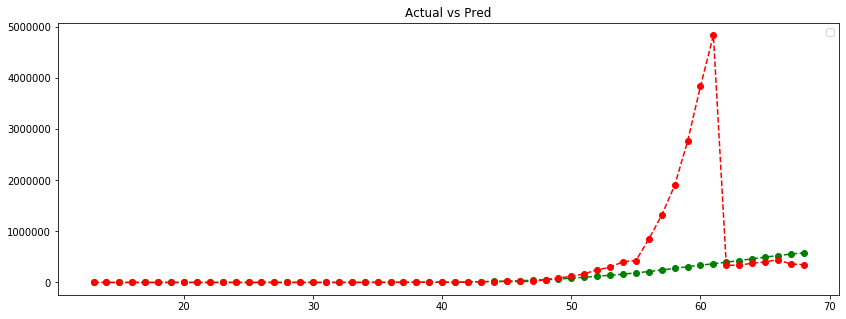

In [103]:
fig, ax = plt.subplots(figsize=(14, 5))
y_preds = [y for x in y_preds for y in x]
yplot = y[first_test_ind:]
ax.plot(yplot, 'go--')
ax.plot(pd.Series(y_preds, index = yplot.index), 'ro--')

plt.title('Actual vs Pred')
plt.legend()
plt.show()

In [99]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)
#X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

### Next linear regression model with some engineered features

In [148]:
cols=['Country','Date','Confirmed']
lag_cols = [col for col in country_df_regres.columns if 'Confirmed_lag_' in col]
train_cols=cols+lag_cols
country_df_regres_conf  = country_df_regres[train_cols]
country_df_regres_conf['month']=country_df_regres_conf['Date'].dt.month 
country_df_regres_conf['dayofweek']=country_df_regres_conf['Date'].dt.dayofweek

C:\Users\pspat\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\pspat\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [183]:
prediction_country = 'United States of America'
df_train = country_df_regres_conf.loc[country_df_regres_conf['Country']==prediction_country]

In [184]:
df_train['seven_day_rolling_mean_confirmed'] = df_train['Confirmed'].rolling(window=7).mean()
weights = np.arange(1,8)
df_train['wgtd_seven_day_rolling_mean_confirmed'] = df_train['Confirmed'].rolling(window=7).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True)

C:\Users\pspat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\pspat\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [185]:
df_train = df_train.dropna()

In [186]:
X = df_train.drop(columns=['Confirmed','Date','Country'])
y = df_train['Confirmed']

In [187]:
y_preds2 = []
mapes2 =  []
model_coefs2 = []
first_test_ind2 = 50000
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    if test_index[0] < first_test_ind2:
        first_test_ind2=test_index[0]
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = LinearRegression()
    model.fit(X_train, y_train)
    model_coefs2.append(model.coef_)
    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred)
    y_preds2.append(y_pred)
    print(y_pred)
    print(y_test)
    mape_val = round((abs((y_pred -y_test) / y_test) * 100).mean())
    print(mape_val)
    mapes2.append(mape_val)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16 17 18 19]
[13. 13. 14. 16. 18. 19. 20.]
14469    13
14470    13
14471    13
14472    15
14473    15
14474    15
14475    15
Name: Confirmed, dtype: int64
13
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20 21 22 23 24 25 26]
[15. 15. 15. 16. 20. 24. 37.]
14476    15
14477    15
14478    16
14479    16
14480    24
14481    30
14482    53
Name: Confirmed, dtype: int64
10
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] TEST: [27 28 29 30 31 32 33]
[ 83. 126. 203. 284. 422. 592. 747.]
14483     73
14484    104
14485    172
14486    217
14487    336
14488    450
14489    514
Name: Confirmed, dtype: int64
27
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33] TEST: [34 35 36 37 38 39 40]
[ 651.  926. 1428. 1994. 2738. 3021. 3497.]
14490     708
14491    1105
14492    1557
14493    2147
14494    

In [188]:
np.mean(mapes2)

12.875

No handles with labels found to put in legend.


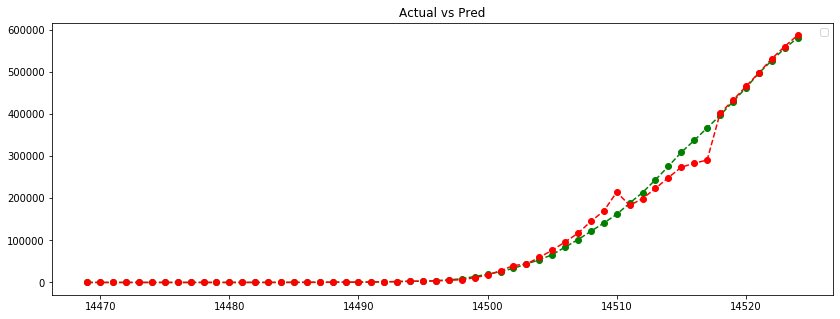

In [189]:
fig, ax = plt.subplots(figsize=(14, 5))
y_preds2 = [y for x in y_preds2 for y in x]
yplot = y[first_test_ind2:]
ax.plot(yplot, 'go--')
ax.plot(pd.Series(y_preds2, index = yplot.index), 'ro--')

plt.title('Actual vs Pred')
plt.legend()
plt.show()

In [190]:
country_df_regres.Country.nunique()

183

In [362]:
mapes_linear_reg = []
for cntry in country_list:
    df_train = country_df_regres.loc[country_df_regres['Country']==cntry]
    df_train = df_train.dropna()
    df_train= df_train.loc[df_train['Confirmed_lag_7']>0]
    df_train = df_train.reset_index()
    df_train['seven_day_rolling_mean_confirmed'] = df_train['Confirmed'].rolling(window=7).mean()
    weights = np.arange(1,8)
    df_train['wgtd_seven_day_rolling_mean_confirmed'] = df_train['Confirmed'].rolling(window=7).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True)
    lag_cols_only =  [col for col in df_train.columns if 'Confirmed_lag_' in col]
    X = df_train[lag_cols_only]
    y = df_train['Confirmed']
    X_train = X.iloc[0:len(X)-7]
    X_test = X.iloc[-7:]
    y_train = y.iloc[0:len(y)-7]
    y_test = y.iloc[-7:]
    
    if len(X) > 13:
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mapes_linear_reg.append((abs((y_pred -y_test) / y_test) * 100).mean())
    else:
        pass

In [364]:
np.mean(mapes_linear_reg)

67.2731176098028

In [370]:
mapes_linear_reg_2 = []
for cntry in country_list:
    df_train = country_df_regres_conf.loc[country_df_regres_conf['Country']==cntry]
    df_train = df_train.dropna()
    df_train= df_train.loc[df_train['Confirmed_lag_7']>0]
    df_train = df_train.reset_index()

    X = df_train.drop(columns=['Confirmed','Date','Country'])
    y = df_train['Confirmed']
    X_train = X.iloc[0:len(X)-7]
    X_test = X.iloc[-7:]
    y_train = y.iloc[0:len(y)-7]
    y_test = y.iloc[-7:]
    
    if len(X) > 13:
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mapes_linear_reg_2.append((abs((y_pred -y_test) / y_test) * 100).mean())
    else:
        pass
    
    
    

In [372]:
np.mean(mapes_linear_reg_2)

61.633489420957076

## Holt Linear Model

In [261]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [302]:
prediction_country = 'Yemen'

In [303]:
df_train = country_df_regres.loc[country_df_regres['Country']==prediction_country]
df_train = df_train.dropna()
df_train= df_train.loc[df_train['Confirmed_lag_7']>0]
df_train = df_train.reset_index()

In [304]:

cols=['Country','Date','Confirmed']
lag_cols_only =  [col for col in df_train.columns if 'Confirmed_lag_' in col]
X = df_train[lag_cols_only]
y = df_train['Confirmed']

In [305]:
num_in_test = 7
test_size = float(num_in_test) / len(X)
n_splits = int((1//test_size)-1)
tscv = TimeSeriesSplit(n_splits=n_splits)

ZeroDivisionError: float division by zero

In [306]:
y_preds_holt = []
mapes_holt =  []
first_test_ind_holt=500000
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    if test_index[0] < first_test_ind_holt:
        first_test_ind_holt=test_index[0]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    holtfit = ExponentialSmoothing(y_train, trend='mul',seasonal=None,damped=True).fit()
    y_pred = holtfit.forecast(7)
    y_preds_holt.append(np.round(y_pred.values))
    mapes_holt.append((abs((y_pred.values -y_test) / y_test) * 100).mean())
    

ValueError: Cannot have number of folds =6 greater than the number of samples: 0.

In [255]:
np.mean(mapes_holt)

53.489616384740074

No handles with labels found to put in legend.


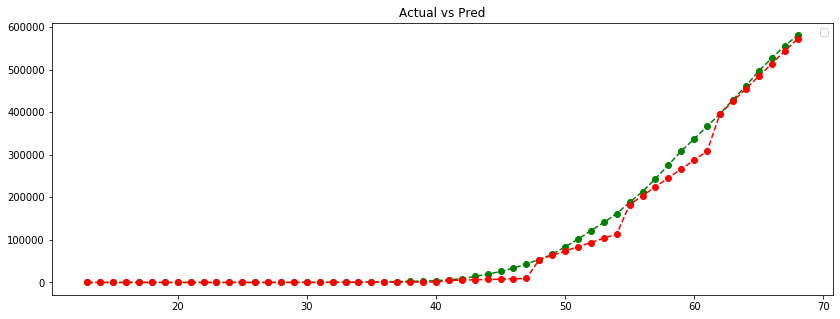

In [214]:
fig, ax = plt.subplots(figsize=(14, 5))
y_preds_holt_plot = [y for x in y_preds_holt for y in x]
yplot = y[first_test_ind_holt:]
ax.plot(yplot, 'go--')
ax.plot(pd.Series(y_preds_holt_plot, index = yplot.index), 'ro--')

plt.title('Actual vs Pred')
plt.legend()
plt.show()

In [209]:
y_preds_holt

[array([13., 13., 13., 13., 13., 13., 13.]),
 array([15., 16., 16., 16., 16., 17., 17.]),
 array([  83.,  136.,  222.,  362.,  591.,  965., 1575.]),
 array([ 644.,  753.,  859.,  959., 1053., 1139., 1217.]),
 array([ 5357.,  6663.,  8193.,  9966., 11998., 14303., 16895.]),
 array([ 55371.,  69001.,  84603., 102187., 121721., 143134., 166315.]),
 array([184445., 208006., 232306., 257135., 282288., 307571., 332800.]),
 array([398253., 429999., 461717., 493239., 524411., 555096., 585175.])]

In [221]:
mapes_holt

[7.773010814699616,
 21.69427888551733,
 76.70217685543943,
 48.1280773403759,
 42.809925859233594,
 1.9914541246140227,
 6.06701514550883,
 0.38946313892654]

In [224]:
country_list = country_df_regres.Country.unique()
country_list

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica', 'Croatia',
       'Cuba', 'Cyprus', 'Czech Republic', "Côte d'Ivoire", 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia',
       'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala',
       'Guinea', 'Guinea-Bissau', 'Guyana', 'H

In [267]:
num_in_test = 7
test_size = float(num_in_test) / len(X)
n_splits = int((1//test_size)-1)
tscv = TimeSeriesSplit(n_splits=n_splits)

In [341]:
mapes_country = []
for cntry in country_list:
    df_train = country_df_regres.loc[country_df_regres['Country']==cntry]
    df_train = df_train.dropna()
    df_train= df_train.loc[df_train['Confirmed_lag_7']>0]
    df_train = df_train.reset_index()
    cols=['Country','Date','Confirmed']
    lag_cols_only =  [col for col in df_train.columns if 'Confirmed_lag_' in col]
    X = df_train[lag_cols_only]
    y = df_train['Confirmed']
    y_preds_holt = []
    mapes_holt =  []

    if len(X) > 13:
        num_in_test = 7
        test_size = float(num_in_test) / len(X)
        n_splits = int((1//test_size)-1)
        if n_splits > 1:
            tscv = TimeSeriesSplit(n_splits=n_splits)
            for train_index, test_index in tscv.split(X):
                y_train = y.iloc[train_index]
                y_test = y.iloc[test_index]
                holtfit = ExponentialSmoothing(y_train, trend='mul',seasonal=None,damped=True).fit()
                y_pred = holtfit.forecast(len(y_test))
                y_preds_holt.append(np.round(y_pred.values))
                mapes_holt.append((abs((y_pred.values -y_test) / y_test) * 100).mean())
            mapes_country.append(np.mean(mapes_holt))
        else:
            y_train = y.iloc[0:len(y)-7]
            y_test = y.iloc[-7:]
            holtfit = ExponentialSmoothing(y_train, trend='mul',seasonal=None,damped=True).fit()
            y_pred = holtfit.forecast(len(y_test))
            y_preds_holt.append(np.round(y_pred.values))
            mapes_country.append((abs((y_pred.values -y_test) / y_test) * 100).mean())
    else:
        pass

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning:

invalid value encountered in greater_equal

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarni

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: Con

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: Con

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: Con

In [343]:
np.mean(mapes_country)

43.17008265715435

In [346]:
mapes_country_holt = []
for cntry in country_list:
    df_train = country_df_regres.loc[country_df_regres['Country']==cntry]
    df_train = df_train.dropna()
    df_train= df_train.loc[df_train['Confirmed_lag_7']>0]
    df_train = df_train.reset_index()
    cols=['Country','Date','Confirmed']
    lag_cols_only =  [col for col in df_train.columns if 'Confirmed_lag_' in col]
    X = df_train[lag_cols_only]
    y = df_train['Confirmed']
    y_preds_holt = []
    mapes_holt =  []

    if len(X) > 13:
        y_train = y.iloc[0:len(y)-7]
        y_test = y.iloc[-7:]
        holtfit = ExponentialSmoothing(y_train, trend='mul',seasonal=None,damped=True).fit()
        y_pred = holtfit.forecast(len(y_test))
        y_preds_holt.append(np.round(y_pred.values))
        mapes_country_holt.append((abs((y_pred.values -y_test) / y_test) * 100).mean())
    else:
        pass

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning:

invalid value encountered in greater_equal

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarni

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [347]:
np.mean(mapes_country_holt)

19.205320609249704

In [353]:
mapes_country_arima = []
for cntry in country_list:
    df_train = country_df_regres.loc[country_df_regres['Country']==cntry]
    df_train = df_train.dropna()
    df_train= df_train.loc[df_train['Confirmed_lag_7']>0]
    df_train = df_train.reset_index()
    cols=['Country','Date','Confirmed']
    lag_cols_only =  [col for col in df_train.columns if 'Confirmed_lag_' in col]
    X = df_train[lag_cols_only]
    y = df_train['Confirmed']
    y_preds_arima = []

    if len(X) > 13:
        try:
            y_train = y.iloc[0:len(y)-7]
            y_test = y.iloc[-7:]
            model_arima=ARIMA(y_train,(2,2,0))
            model_arima_fit=model_arima.fit()
            y_pred = model_arima_fit.forecast(len(y_test))[0]
            mapes_country_arima.append((abs((y_pred -y_test) / y_test) * 100).mean())
        except:
            pass
    else:
        pass

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1866: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:670: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\pspat\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:672: Runtim

In [355]:
np.mean(mapes_country_arima)

13.424352906953903

In [379]:
mapes_country_proph = []
for cntry in country_list:
    df_cntry = country_df_regres.loc[country_df_regres['Country']==cntry]
    df_cntry = df_cntry.dropna()
    df_cntry= df_cntry.loc[df_cntry['Confirmed_lag_7']>0]
    df_cntry = df_cntry.reset_index()
    df_fb_prophet = df_cntry[['Date','Confirmed']]
    df_fb_prophet.rename(columns={'Date':'ds','Confirmed':'y'},inplace=True)
    df_fb_prophet['ds']=df_fb_prophet['ds'].apply(lambda x: x.date())
    
    if len(X) > 13:
        try:
            df_train = df_fb_prophet.iloc[0:len(df_fb_prophet)-7]
            prophet_model=Prophet()
            prophet_model.fit(df_train)
            future = prophet_model.make_future_dataframe(periods=7)
            forecast = prophet_model.predict(future)
            forecast=forecast[-7:]
            y_pred = forecast['yhat'].values
            y_test = df_fb_prophet.iloc[-7:]['y']
            mapes_country_proph.append(round((abs((y_pred -y_test) / y_test) * 100).mean()))
        
        except:
            pass
    else:
        pass

C:\Users\pspat\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run p

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.
INFO:fbprophet:Disabling yearly seasonality. Run 

INFO:fbprophet:n_changepoints greater than number of observations. Using 12.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disab

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 4.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabl

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabl

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:Disabling yearly seasonality. Run 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


In [380]:
np.mean(mapes_country_proph)

21.565714285714286

In [374]:
mapes_country_proph

[]

In [377]:
y_pred

array([10.40485216, 10.80552359, 11.20619503, 11.60686646, 12.0075379 ,
       12.40820933, 12.80888077])